<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Neural Network Framework (Keras)

## *Data Science Unit 4 Sprint 2 Assignmnet 3*

## Use the Keras Library to build a Multi-Layer Perceptron Model on the Boston Housing dataset

- The Boston Housing dataset comes with the Keras library so use Keras to import it into your notebook. 
- Normalize the data (all features should have roughly the same scale)
- Import the type of model and layers that you will need from Keras.
- Instantiate a model object and use `model.add()` to add layers to your model
- Since this is a regression model you will have a single output node in the final layer.
- Use activation functions that are appropriate for this task
- Compile your model
- Fit your model and report its accuracy in terms of Mean Squared Error
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Run this same data through a linear regression model. Which achieves higher accuracy?
- Do a little bit of feature engineering and see how that affects your neural network model. (you will need to change your model to accept more inputs)
- After feature engineering, which model sees a greater accuracy boost due to the new features?

In [264]:
import pandas as pd
df = pd.read_csv(r'module3-Intro-to-Keras\Data\ameshouseprice.csv')
print(df.shape)
df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [265]:
df.isnull().sum().sort_values(ascending=False)[:10]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
dtype: int64

In [266]:
# Let's drop the columns with over 500 nan values
drops = df.isnull().sum().sort_values(ascending=False)[:5].index.tolist()
# And remove the Id feature
drops.append('Id')
drops

['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'Id']

In [267]:
data = df.drop(drops, axis=1).copy()
data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,112,0,0,0,0,4,2010,WD,Normal,142125


In [268]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
import category_encoders as ce

In [269]:
encoder = ce.OneHotEncoder()
encoded = encoder.fit_transform(data)
drops1 = encoded.isnull().sum().sort_values(ascending=False)[:3].index.tolist()
drops1

['LotFrontage', 'GarageYrBlt', 'MasVnrArea']

In [270]:
df1 = encoded.drop(drops1, axis=1).copy()
df1

,MSSubClass,MSZoning_1,MSZoning_2,MSZoning_3,MSZoning_4,MSZoning_5,LotArea,Street_1,Street_2,LotShape_1,...,SaleType_7,SaleType_8,SaleType_9,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5,SaleCondition_6,SalePrice
0,60,1,0,0,0,0,8450,1,0,1,...,0,0,0,1,0,0,0,0,0,208500
1,20,1,0,0,0,0,9600,1,0,1,...,0,0,0,1,0,0,0,0,0,181500
2,60,1,0,0,0,0,11250,1,0,0,...,0,0,0,1,0,0,0,0,0,223500
3,70,1,0,0,0,0,9550,1,0,0,...,0,0,0,0,1,0,0,0,0,140000
4,60,1,0,0,0,0,14260,1,0,0,...,0,0,0,1,0,0,0,0,0,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,1,0,0,0,0,7917,1,0,1,...,0,0,0,1,0,0,0,0,0,175000
1456,20,1,0,0,0,0,13175,1,0,1,...,0,0,0,1,0,0,0,0,0,210000
1457,70,1,0,0,0,0,9042,1,0,1,...,0,0,0,1,0,0,0,0,0,266500
1458,20,1,0,0,0,0,9717,1,0,1,...,0,0,0,1,0,0,0,0,0,142125


In [271]:
df1_stats = df1.describe()
df1_stats.pop('SalePrice')
df1_stats = df1_stats.transpose()
df1_stats

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.0,56.897260,42.300571,20.0,20.0,50.0,70.0,190.0
MSZoning_1,1460.0,0.788356,0.408614,0.0,1.0,1.0,1.0,1.0
MSZoning_2,1460.0,0.149315,0.356521,0.0,0.0,0.0,0.0,1.0
MSZoning_3,1460.0,0.006849,0.082505,0.0,0.0,0.0,0.0,1.0
MSZoning_4,1460.0,0.044521,0.206319,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
SaleCondition_2,1460.0,0.069178,0.253844,0.0,0.0,0.0,0.0,1.0
SaleCondition_3,1460.0,0.085616,0.279893,0.0,0.0,0.0,0.0,1.0
SaleCondition_4,1460.0,0.002740,0.052289,0.0,0.0,0.0,0.0,1.0
SaleCondition_5,1460.0,0.008219,0.090317,0.0,0.0,0.0,0.0,1.0


In [272]:
def norm(x):
  return (x - df1_stats['mean']) / df1_stats['std']
X = norm(df1).values
y = data['SalePrice'].values

In [273]:
X.shape, y.shape

((1460, 279), (1460,))

In [323]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

In [241]:
model = Sequential()

model.add(Dense(100, input_dim=278, activation='relu', name='In'))
model.add(Dense(100, activation='relu', name='2'))
model.add(Dense(100, activation='relu', name='3'))
# model.add(Dense(50, activation='selu', name='4'))
model.add(Dense(1, name='Out'))

model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse'])
model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
In (Dense)                   (None, 100)               27900     
_________________________________________________________________
2 (Dense)                    (None, 100)               10100     
_________________________________________________________________
3 (Dense)                    (None, 100)               10100     
_________________________________________________________________
Out (Dense)                  (None, 1)                 101       
Total params: 48,201
Trainable params: 48,201
Non-trainable params: 0
_________________________________________________________________


In [242]:
history = model.fit(X,y, epochs=200, validation_split=.2)

Train on 1168 samples, validate on 292 samples
Epoch 1/200
1168/1168 [==============================] - 1s 811us/sample - loss: 38813588774.5753 - mae: 180575.7344 - mse: 38813581312.0000 - val_loss: 39892779456.8767 - val_mae: 182184.2656 - val_mse: 39892779008.0000
Epoch 2/200
1168/1168 [==============================] - 0s 158us/sample - loss: 38660894383.3425 - mae: 180234.6875 - mse: 38660894720.0000 - val_loss: 39432400054.3562 - val_mae: 181186.9531 - val_mse: 39432400896.0000
Epoch 3/200
1168/1168 [==============================] - 0s 164us/sample - loss: 37096088169.2055 - mae: 176856.8281 - mse: 37096091648.0000 - val_loss: 36258032149.0411 - val_mae: 174210.9844 - val_mse: 36258029568.0000
Epoch 4/200
1168/1168 [==============================] - 0s 146us/sample - loss: 30556651940.8219 - mae: 161351.5625 - mse: 30556649472.0000 - val_loss: 25994911603.7260 - val_mae: 148318.5938 - val_mse: 25994911744.0000
Epoch 5/200
1168/1168 [==============================] - 0s 155us/sam

In [243]:
to_plot = pd.DataFrame(history.history)
to_plot['epoch'] = history.epoch
to_plot

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,3.881359e+10,180575.734375,3.881358e+10,3.989278e+10,182184.265625,3.989278e+10,0
1,3.866089e+10,180234.687500,3.866089e+10,3.943240e+10,181186.953125,3.943240e+10,1
2,3.709609e+10,176856.828125,3.709609e+10,3.625803e+10,174210.984375,3.625803e+10,2
3,3.055665e+10,161351.562500,3.055665e+10,2.599491e+10,148318.593750,2.599491e+10,3
4,1.684899e+10,119276.742188,1.684899e+10,1.230114e+10,93874.304688,1.230114e+10,4
...,...,...,...,...,...,...,...
195,6.430979e+07,4242.187012,6.430978e+07,1.868083e+09,24530.464844,1.868083e+09,195
196,6.417907e+07,4215.737305,6.417907e+07,1.855569e+09,24393.769531,1.855569e+09,196
197,6.227637e+07,4153.984375,6.227637e+07,1.873203e+09,24485.996094,1.873203e+09,197
198,6.108134e+07,4054.669922,6.108134e+07,1.877358e+09,24510.630859,1.877358e+09,198


In [244]:
import matplotlib.pyplot as plt
import seaborn as sns

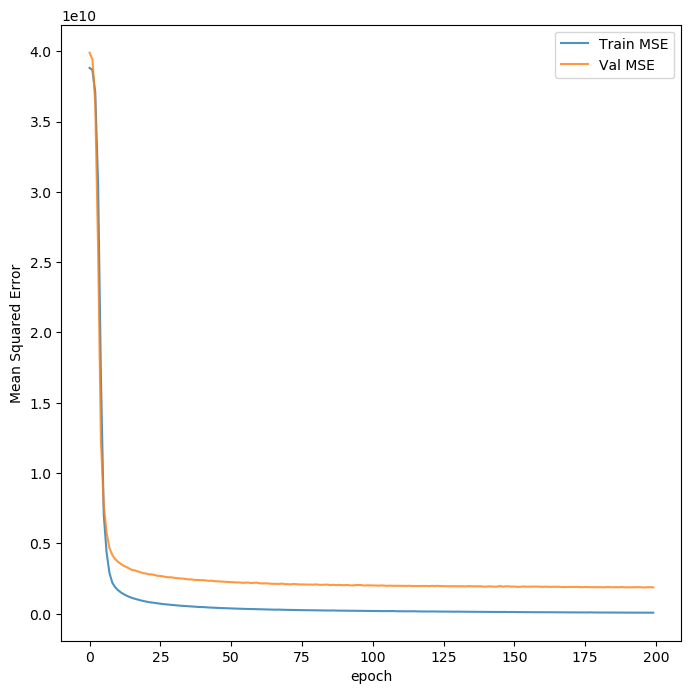

In [245]:
with plt.style.context('default'):
    fig, ax = plt.subplots(figsize=(8,8))
    sns.lineplot(data=to_plot, x='epoch', y='mse', label='Train MSE', alpha=.8)
    sns.lineplot(data=to_plot, x='epoch', y='val_mse', label='Val MSE', alpha=.8)
    ax.set_ylabel('Mean Squared Error')

In [246]:
val_mae = to_plot['val_mae'].min()
val_mse = to_plot['val_mse'].min()

In [247]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rfr = RandomForestRegressor(n_jobs=-1, random_state=42, n_estimators=500)
rfr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [248]:
y_pred = rfr.predict(X_test)

In [249]:
print('Using Random Forest Regressor: \n', f'MAE: ${mean_absolute_error(y_pred,y_test):,.02f} \n', f'MSE: ${mean_squared_error(y_pred, y_test):,.02f}')
print('Using Multilayer Perceptron Model: \n', f'MAE: ${val_mae:,.02f} \n', f'MSE: ${val_mse:,.02f}')

Using Random Forest Regressor: 
 MAE: $17,293.70 
 MSE: $803,226,762.19
Using Multilayer Perceptron Model: 
 MAE: $24,388.50 
 MSE: $1,855,569,152.00


## Use the Keras Library to build an image recognition network using the Fashion-MNIST dataset (also comes with keras)

- Load and preprocess the image data similar to how we preprocessed the MNIST data in class.
- Make sure to one-hot encode your category labels
- Make sure to have your final layer have as many nodes as the number of classes that you want to predict.
- Try different hyperparameters. What is the highest accuracy that you are able to achieve.
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Remember that neural networks fall prey to randomness so you may need to run your model multiple times (or use Cross Validation) in order to tell if a change to a hyperparameter is truly producing better results.

In [327]:
from tensorflow.keras.datasets import fashion_mnist
(X, y), (X_test, y_test) = fashion_mnist.load_data()

In [328]:
# Normalize Our Data
X = X / 255

In [329]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y)

In [330]:
X.shape, y.shape

((60000, 28, 28), (60000, 10))

In [331]:
import numpy as np
sampler = np.random.randint(60000, size=10000)
X = X[sampler]
y = y[sampler]

In [332]:
X.shape, y.shape

((10000, 28, 28), (10000, 10))

In [368]:
model = Sequential([
    Flatten(input_shape=(28,28), name='Flatten_Images'),
    Dense(100, activation='relu', name='In'),
    Dense(50, activation='relu', name='1'),
    Dense(10, activation='softmax', name='Out')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'mae'])
model.summary()

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten_Images (Flatten)     (None, 784)               0         
_________________________________________________________________
In (Dense)                   (None, 100)               78500     
_________________________________________________________________
1 (Dense)                    (None, 50)                5050      
_________________________________________________________________
Out (Dense)                  (None, 10)                510       
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
_________________________________________________________________


In [369]:
history = model.fit(X,y, epochs=50, validation_split=.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 [==============================] - 2s 202us/sample - loss: 0.7691 - accuracy: 0.7352 - mae: 0.0796 - val_loss: 0.5687 - val_accuracy: 0.7995 - val_mae: 0.0586
Epoch 2/50
8000/8000 [==============================] - 1s 104us/sample - loss: 0.5015 - accuracy: 0.8207 - mae: 0.0534 - val_loss: 0.5124 - val_accuracy: 0.8120 - val_mae: 0.0491
Epoch 3/50
8000/8000 [==============================] - 1s 104us/sample - loss: 0.4494 - accuracy: 0.8385 - mae: 0.0474 - val_loss: 0.5077 - val_accuracy: 0.8150 - val_mae: 0.0495
Epoch 4/50
8000/8000 [==============================] - 1s 106us/sample - loss: 0.3989 - accuracy: 0.8521 - mae: 0.0433 - val_loss: 0.4400 - val_accuracy: 0.8405 - val_mae: 0.0434
Epoch 5/50
8000/8000 [==============================] - 1s 104us/sample - loss: 0.3790 - accuracy: 0.8636 - mae: 0.0405 - val_loss: 0.4580 - val_accuracy: 0.8385 - val_mae: 0.0432
Epoch 6/50
8000/8000 [==============================

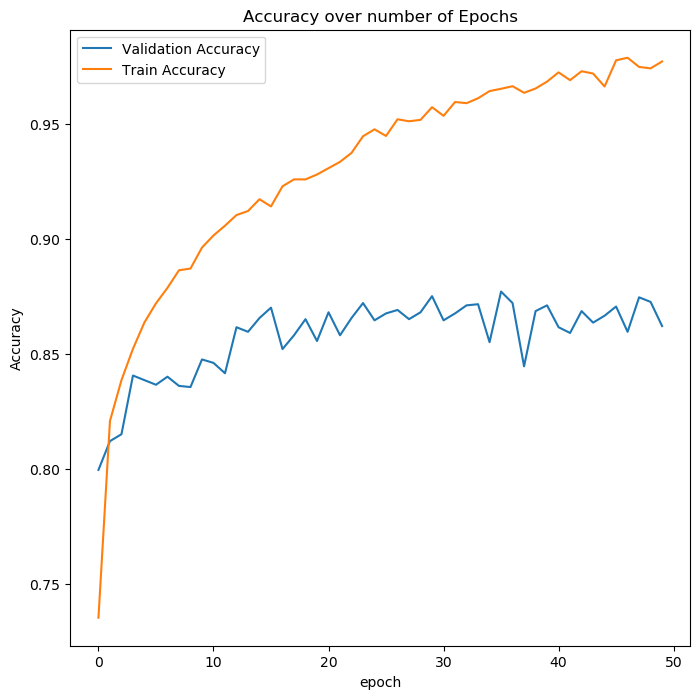

In [370]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
with plt.style.context('default'):
    fig, ax = plt.subplots(figsize=(8,8))
    sns.lineplot(data=hist, x='epoch', y='val_accuracy', label='Validation Accuracy')
    sns.lineplot(data=hist, x='epoch', y='accuracy', label='Train Accuracy')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy over number of Epochs')

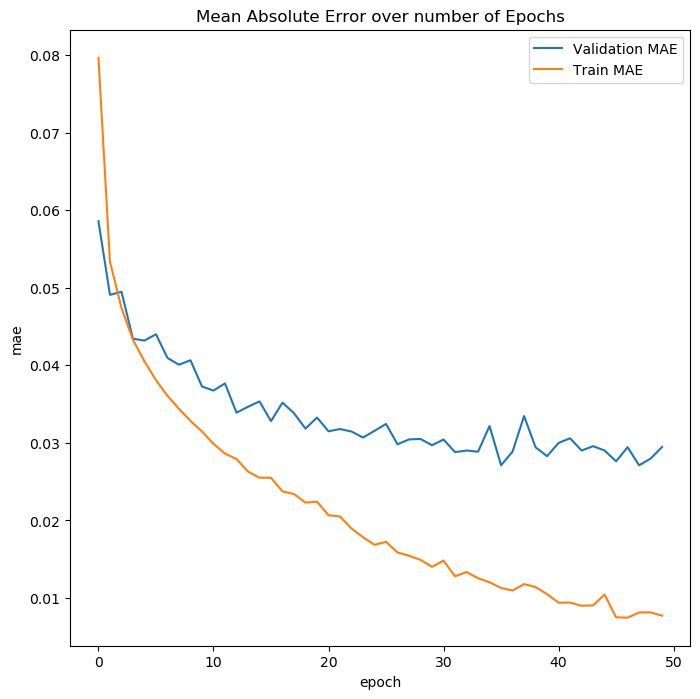

In [371]:
with plt.style.context('default'):
    fig, ax = plt.subplots(figsize=(8,8))
    sns.lineplot(data=hist, x='epoch', y='val_mae', label='Validation MAE')
    sns.lineplot(data=hist, x='epoch', y='mae', label='Train MAE')
    ax.set_title('Mean Absolute Error over number of Epochs')

This is a great example of overfitting/overly complex model. While the training data is getting better and better fit, resulting in lower MAE and higher Accuracy scores, we see the validation set oscilating around 85% accuracy and .035 MAE. I would normally go back and adjust the model to save time computing but I think this is a cool example and an easy way to see it!

## Stretch Goals:

- Use Hyperparameter Tuning to make the accuracy of your models as high as possible. (error as low as possible)
- Use Cross Validation techniques to get more consistent results with your model.
- Use GridSearchCV to try different combinations of hyperparameters. 
- Start looking into other types of Keras layers for CNNs and RNNs maybe try and build a CNN model for fashion-MNIST to see how the results compare.